In [171]:
# from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import clear_output

import pandas as pd
import numpy as np
import scipy.optimize
import re
import os
import importlib
from collections import OrderedDict
import itertools
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter, FuncFormatter

import trmc.kin as kin
import trmc.load as load
import trmc.analysis as analysis
import trmc.plot as plot
from trmc.plot import exp_formatter

%matplotlib inline
mpl.rcParams['figure.figsize'] = [8, 8]
mpl.rc('font',**{'size' : 16})

e0 = 8.854e-12

In [172]:
%store -r da_dv
%store -r da_bv
%store -r da_sw
%store -r da_dcs

da_dv = da_dv.load()

## Raw Delta V 

In [173]:
col = None if (len(da_dv.indexes['sample']) == 1)  else 'sample'
row = None if (len(da_dv.indexes['direction']) == 1)  else 'direction'
timeslice = slice(0e-9,1000e-9)

## Interpolate the dark cavity sweep to match with the delta v data array

In [174]:
da_dcsi = da_dcs.interp_like(da_dv,method = 'nearest')

For now just pull out one freqt

In [175]:
# For partial data sets, cut down the dark cavity sweep, not sure if this is nessecary
# fmin = da_dv.indexes['freq'].min()
# fmax = da_dv.indexes['freq'].max()
# idxmin = abs(da_dcs.indexes['freq'] - fmin).argmin()
# idxmax = abs(da_dcs.indexes['freq'] - fmax).argmin() + 1 #???

idx = -10
das = []
for samp in da_dcsi.indexes['sample']:
    freqt = da_dcsi.sel(sample = samp).dropna('freqt','all').indexes['freqt'][idx]
    das.append(da_dcsi.sel(sample = samp).sel(freqt = freqt).drop('freqt').dropna('freq','all'))
    
v0s = xr.concat(das, dim = 'sample')

In [176]:
# samples = da_bv.indexes['sample']
# size = len(samples)
# fig, axes = plt.subplots(1,size, figsize = (5*size,4*size) , sharey = True, squeeze=False)

# for i, samp in enumerate(samples):
#     swp_bv_u = da_bv.sel(sample = samp, direction = 'U').dropna('freq','all')
#     axes[0][i].plot(swp_bv_u.indexes['freq'],swp_bv_u,marker = 'o', label = 'Up')
#     swp_init = da_sw.sel(sample = samp, tc = '_1_', swtime = 0)
#     axes[0][i].plot(swp_init.indexes['freq'],swp_init,marker = 'o',label = 'Initial')
#     v0= v0s.sel(sample = samp,direction = 'U').dropna('freq','all')
#     axes[0][i].plot(v0.to_series(),marker = 'o',label = 'v0')
#     axes[0][i].set_title(samp)
#     axes[0][i].legend()
#     axes[0][i].set_xlabel('Frequency')
#     axes[0][0].set_ylabel('Voltage(V)') 

#     fig.tight_layout()

## fitting setup

Define fit parameters

In [177]:
fittype = 'lor'
# fittype = 'poly'

if fittype == 'lor':
    Rinf = 0.02125
    f0 = None
    p0 =[f0,0.01,Rinf,1e7]
    p_labels = ['f0','R0','Rinf','w'] 
    epsilon = 0.001 #problems with fixing R0 when this gets too smalll??? fit does not respond to bounds on R0 properly...
    window = 100
    samps = v0s.indexes['sample']
    Ks = pd.Series(index = samps) #Define only for lorentzian as poly fits need Ks
    fixR0 = True

# TODO: need to pass out all covariance only happening for one lor fn
    
elif fittype == 'poly':
    window = 2
    p_labels = [ 'f0','R0', 'p0','p1','p2']
    bounds = ([-np.inf,-np.inf,-np.inf],[np.inf,np.inf,np.inf])
    p0 = [.01,1e-9,1e-18]
    

time1 = 0e-9
time2 = 1800e-9
timerange = slice(time1,time2)
timestep = 10e-9 #not index and has been moved inside for loop...need to check

# direcs = v0s.indexes['direction'].values
direcs = ['U']

samps = v0s.indexes['sample']
# samps = ['bia','bid']
flus = slice(-1,0,-1)
seldicts = list(analysis.dict_product({'sample' :samps, 'direction':direcs}))


Initialize data and perform fits

In [178]:
###Setup dictionaries to input paramters into
da_p = da_dv.isel(freq = 0).drop('freq').where(False).copy()
da_p0 = da_dcs.isel(freqt = 0).drop('freqt').isel(freq = 0).drop('freq').where(False).copy()

da_p_dict = {}
da_p0_dict = {}
for p in p_labels:
    da_p_dict[p] = da_p
    da_p0_dict[p] = da_p0
    
#Not exactly sure why I have to do this copying. Otherwise I think the reference to the original numpy array is kept and assignments get all weird
ds_p = xr.Dataset(da_p_dict).copy(deep=True)
ds_p0 = xr.Dataset(da_p0_dict).copy(deep=True)

ds_p_r  =  ds_p.sel(time = timerange).copy(deep = True).where(False)   #nessecary, subselection is currently not done for ds_p0
ds_cov_r  =  ds_p.sel(time = timerange).copy(deep = True).where(False)   #nessecary, subselection is currently not done for ds_p0


###Generate Vshift data array
dvs = da_dv.sel(time = timerange)
vss = v0s + dvs

###Create data arrays to put fits into
fits_v0 = v0s.copy(deep= True).where(False)
fits = dvs.copy(deep = True).where(False)

#numer of fits for percent indicator, not working. 
num = len(seldicts)*(abs(flus.stop - flus.start))
### FITTING

for seldict in seldicts:
    clear_output(wait = True)
    
    ### V0 fitting
    v0 = v0s.sel(seldict).dropna('freq','all')
    samp = seldict['sample']
    direc = seldict['direction']
    if fittype == 'lor':
        ##Set minimum frequency to minimum of data
        p0[0] = None    
        p0 =[f0,0.01,Rinf,1e7]
        bounds = ([0,0,0, 0],[np.inf,np.inf,np.inf, np.inf])
    v0_fit, v0_p,v0_sl = analysis.fitsweep(v0, p0, bounds, window , fittype,p_labels)
    popt = v0_p[0]
    Rinfv0 = popt[2]
    freqs = v0.indexes['freq'][v0_sl]
    fits_v0.loc[samp,direc,freqs] = v0_fit(freqs)

    for j, p in enumerate(ds_p0.data_vars):
        ds_p0[p].loc[samp,direc] = popt[j]
    
    if fittype == 'lor':
        Ks[samp] = analysis.calc_K(f0 = popt[0], R0_norm = popt[1]/popt[2],w = popt[3], printparams = False)
    elif fittype =='poly':
        print('poly fit, using old K value (do lorentzian fit first)')
    print('K sample ' + samp + ' = ' + str(Ks.loc[samp]))
    
    ###Time Series fitting
    
    vs1 = vss.sel(seldict).dropna('fluence','all').dropna('freq','all').dropna('time','all')
    
    times = vs1.indexes['time']
    timeidx1 = pd.Series(abs(times-time1)).idxmin()
    timeidx2 = pd.Series(abs(times-time2)).idxmin()
    dt = times[1] - times[0]
    idxstep = int(timestep/dt)
    
    fittimes = times[slice(timeidx1,timeidx2,idxstep)]
#     print('fitting for time idxs ' + str(fittimes) )
    
    i=0
    numflus = len(vs1.indexes['fluence'][flus.start:flus.stop:flus.step])
    for flu in vs1.indexes['fluence'][flus]:
        vs2 = vs1.sel(fluence = flu)
        
        print(str((i/numflus)*100.0) + ' %') 
        i=i+1
        for time in fittimes:
            vs3 = vs2.dropna('freq','all').sel(time = time)
            if fittype == 'lor':
                ##Set minimum frequency to minimum of data
                p0[0] = None
                p0[2] = Rinfv0 
#                 p0 =[f0,0.01,Rinfv0,1e7]
                if fixR0:
                    bounds = ([0,0,Rinfv0 - epsilon,0 ],[np.inf,np.inf,Rinfv0 + epsilon,np.inf ])
                else:
                    bounds = ([0,0,0, 0],[np.inf,np.inf,np.inf, np.inf])
            vs_fit, vs_p,vs_sl = analysis.fitsweep(vs3, p0, bounds, window , fittype,p_labels)
            popt = vs_p[0]
            pcov = vs_p[1]
            perr = np.sqrt(np.diag(pcov))

            freqs = vs3.indexes['freq'][vs_sl]
            fits.loc[samp,direc,freqs,flu,time] = vs_fit(freqs).values   # Note that freqs is also in the index, only updating the freqeuncies that correspond to that sample
            
            #Fill paramter data sets
            
            if fittype == 'lor':
                ds_p_r['f0'].loc[samp,direc,flu,time] = popt[0]
                ds_p_r['R0'].loc[samp,direc,flu,time] = popt[1]
                ds_p_r['Rinf'].loc[samp,direc,flu,time] = popt[2]
                ds_p_r['w'].loc[samp,direc,flu,time] = popt[3]

                ds_cov_r['f0'].loc[samp,direc,flu,time] = perr[0]
                ds_cov_r['R0'].loc[samp,direc,flu,time] = perr[1]
                ds_cov_r['Rinf'].loc[samp,direc,flu,time] = perr[2]
                ds_cov_r['w'].loc[samp,direc,flu,time] = perr[3]
            elif fittype == 'poly':
                ds_p_r['f0'].loc[samp,direc,flu,time] = popt[1]
                ds_p_r['R0'].loc[samp,direc,flu,time] = popt[0]
                
                ds_cov_r['f0'].loc[samp,direc,flu,time] = perr[1]
                ds_cov_r['R0'].loc[samp,direc,flu,time] = perr[0]
                    
fits.name = 'fits'
dvs.name = 'dvs'
vss.name = 'vss'
            
das = [dvs,fits,vss]
ds = xr.merge(das)
print('done')

K sample cs = 80607.41393301757
0.0 %
33.33333333333333 %
66.66666666666666 %
done


# Visualizing Fit results 

In [190]:
import importlib
importlib.reload(plot)

<module 'trmc.plot' from 'C:\\Users\\aspit\\Documents\\Git\\TRMC\\trmc\\plot.py'>

In [195]:
%matplotlib ipympl
mpl.rc('font',**{'size' : 16})

# samp = v0s.indexes['sample'][0]
samp = 'cs'

### Pull out arrays for one sample and get rid of nas
dst = ds.sel(sample = samp).sel(direction = 'U').drop('direction')#.sel(time = times) #try drop any fluence nan...

fits_samp = dst['fits'].dropna('fluence','all').dropna('freq','all').dropna('time','all').isel(fluence = -1)#.isel(time = 0)
fittimes = fits_samp.indexes['time']
#cut down dvs and fits to only fit times. 
dvs_samp = dst['dvs'].sel(time = fittimes).dropna('fluence','all').dropna('freq','all').dropna('time','all').isel(fluence = -1)#.isel(time = 0)
vss_samp = dst['vss'].sel(time = fittimes).dropna('fluence','all').dropna('freq','all').dropna('time','all').isel(fluence = -1)#.isel(time = 0)
dst_samp = xr.merge([dvs_samp,fits_samp,vss_samp])


### Setup initial plot with items at time =0 eventually should be removed
v0 = v0s.sel(sample = samp).sel(direction = 'U').drop('direction').dropna('freq','all')
fit_v0 = fits_v0.loc[samp].sel(direction = 'U').drop('direction').dropna('freq','all')
dv = dst_samp['dvs'].isel(time = 0 )
fit = dst_samp['fits'].isel(time = 0 )
vs = dst_samp['vss'].isel(time = 0 )

# human readable time array for slider
hrtimes = fittimes.values*1e9
hrtimetup = (hrtimes[0],hrtimes[-1],hrtimes[1]-hrtimes[0])

fig, axes, lns = plot.vsplotxr(dv, vs = vs, fit = None, v0 = v0, fit_v0 = None, plotkwargs={'figsize' : (10,8)})

buffer = (dvs_samp.max() - dvs_samp.min())/10
axes[0].set_ylim([dvs_samp.min()-buffer,dvs_samp.max()+buffer])
# axes[0].margins(y = 0.2)

interact(plot.inter_vsplot, timesel=hrtimetup   ,dst_samp = fixed(dst_samp),lns = fixed(lns), fig = fixed(fig));

FigureCanvasNbAgg()

interactive(children=(FloatSlider(value=890.0, description='timesel', max=1790.0, step=10.0), Output()), _dom_…

In [181]:
#plot.sweepfitanim(dst, interval = 100)   # Not currently working

In [182]:
# ds_p_r['Rinf'].isel(fluence = -1).sel(direction = 'D').sel(sample = 'bia').dropna('time').plot()

## Fit error 

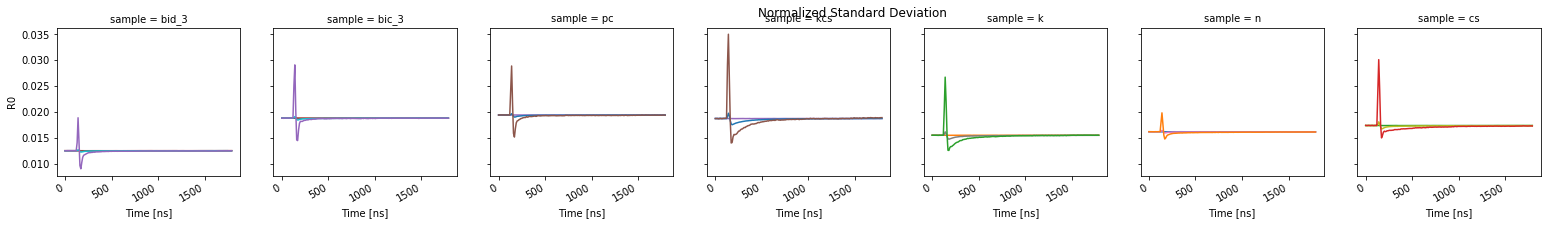

In [183]:
%matplotlib inline

g = (ds_cov_r['R0']/ds_p_r['R0']).sel(direction = 'U').dropna('fluence','all').plot(hue = 'fluence', col = col)

axes = g.axes.flatten() if type(g) is xr.plot.facetgrid.FacetGrid else [g[0].axes]
fig = g.fig if type(g) is xr.plot.facetgrid.FacetGrid else g[0].figure

for ax in axes:
#     ax.set_yscale('log')
#     ax.set_ylim([-1,2])
    ax.xaxis.set_major_formatter(FuncFormatter(plot.exp_formatter(-9).func))
    
    lns = ax.lines
    for ln in lns:
        plot.dropna_ln(ln)
        
fig.suptitle('Normalized Standard Deviation')
# fig.tight_layout()
fig.autofmt_xdate()

if len(fig.legends) > 0:
    fig.legends[0].remove()
else:
    ax.get_legend().remove()

## Calculating the complex conductance 


In [184]:
F=1

ft = ds_p_r['f0']#.sel(direction =direc)
f0 = ft.isel(time = 0)
sigi = -1*(ft-f0)*e0/F
sigiu = -1*(ds_cov_r['f0'])*e0/F

# Calculate conductance from FWHM
# wt = ds_p_r['w']
# w0 = wt.isel(time = 0)
# deltaFWHM = wt - w0
# sigr = deltaFWHM*e0/(2*F)

# Calculate real conductance from deltaR/R   
def R02cond(R0t):
    samp = R0t.coords['sample'].values.item()
    K = Ks[samp]
    R0t0 = R0t.dropna('time','all').isel(time = 0)
    cond = ((R0t-R0t0)/R0t0)/K
    return cond

sigr = ds_p_r['R0'].groupby('sample').apply(R02cond)

# sigr.name = '$\Delta G_r $ (S)'
# sigi.name = '$\Delta G_i $ (S)'


sigr.name = 'real'
sigi.name = 'im'

sigr.attrs = {'units': 'S', 'long_name': '$\Delta G_r $'}
sigi.attrs = {'units': 'S', 'long_name': '$\Delta G_i $'}

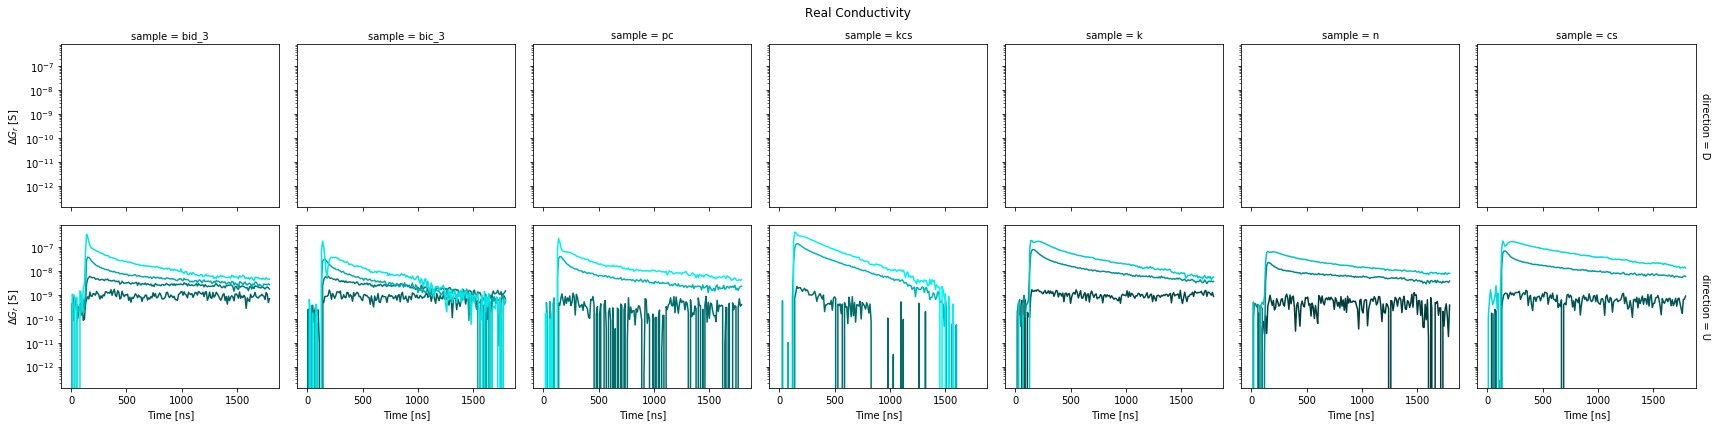

In [185]:
g = sigr.plot(x = 'time',hue = 'fluence',col = col, row = row )

axes = g.axes.flatten() if type(g) is xr.plot.facetgrid.FacetGrid else [g[0].axes]
fig = g.fig if type(g) is xr.plot.facetgrid.FacetGrid else g[0].figure

for ax in axes:
    ax.set_yscale('log')
    ax.xaxis.set_major_formatter(FuncFormatter(plot.exp_formatter(-9).func))
#     ax.set_ylim([1e-9,2e-6])
    lns = ax.lines
    for i, ln in enumerate(lns):
        plot.dropna_ln(ln)
        color = (0,i/len(lns),i/len(lns))
        ln.set_color(color)
    
        
fig.suptitle('Real Conductivity')
# fig.tight_layout()
fig.legends[0].remove() if len(fig.legends) > 0 else ax.get_legend().remove()
fig.tight_layout(rect = [0,0,1,0.95])

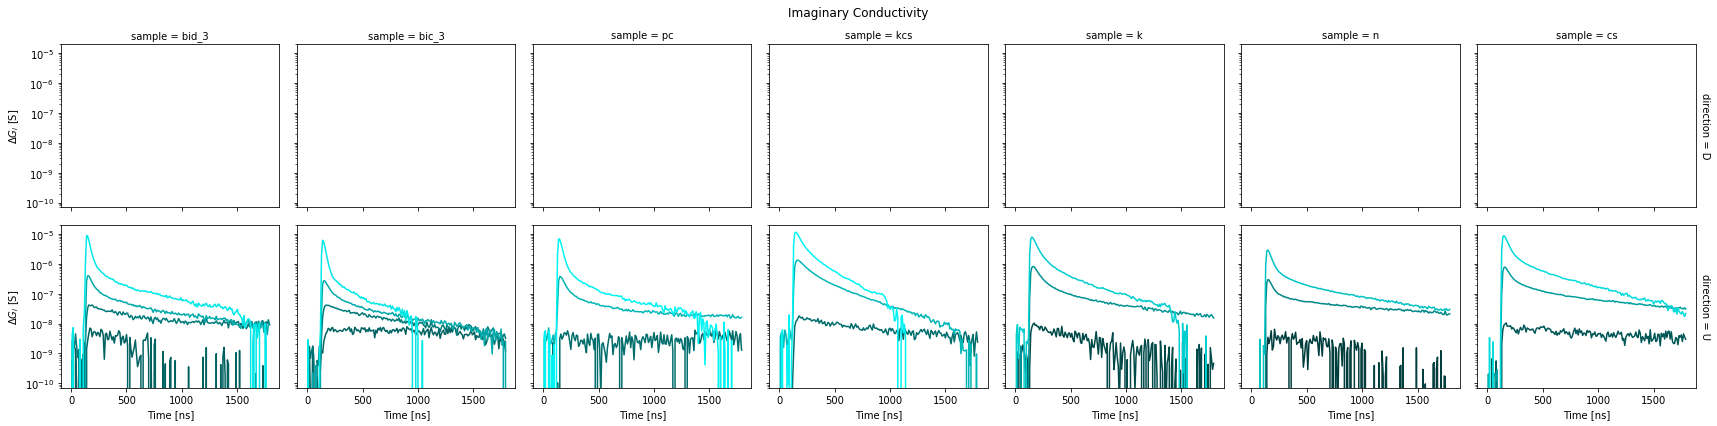

In [186]:
col = None if (len(da_dv.indexes['sample']) == 1)  else 'sample'
row = None if (len(da_dv.indexes['direction']) == 1)  else 'direction'
g = sigi.plot(x = 'time',hue = 'fluence',col = col, row = row )

axes = g.axes.flatten() if type(g) is xr.plot.facetgrid.FacetGrid else [g[0].axes]
fig = g.fig if type(g) is xr.plot.facetgrid.FacetGrid else g[0].figure

for ax in axes:
    ax.set_yscale('log')
    ax.xaxis.set_major_formatter(FuncFormatter(plot.exp_formatter(-9).func))
#     ax.set_ylim([1e-9,2e-4])
    lns = ax.lines
    for i, ln in enumerate(lns):
        plot.dropna_ln(ln)
        color = (0,i/len(lns),i/len(lns))
        ln.set_color(color)
        
fig.suptitle('Imaginary Conductivity')
# fig.tight_layout()

fig.legends[0].remove() if len(fig.legends) > 0 else ax.get_legend().remove()
fig.tight_layout(rect = [0,0,1,0.95])

In [187]:
%store sigr
%store sigi

Stored 'sigr' (DataArray)
Stored 'sigi' (DataArray)


### Uncertianty calculation 

In [188]:
# import uncertainties.unumpy as unp

# R0u = unp.uarray(ds_p_r['R0'].values,ds_cov_r['R0'].values)
# daR0u = xr.DataArray(R0u, coords = ds_p_r['R0'].coords, dims = ds_p_r['R0'].dims)
# sigruarr= daR0u.groupby('sample').apply(R02cond)
    
# sigr = unp.nominal_values(sigruarr.values)
# sigru = unp.std_devs(sigruarr.values)
# sigr = xr.DataArray(sigr, coords = ds_p_r['R0'].coords, dims = ds_p_r['R0'].dims)
# sigru = xr.DataArray(sigru, coords = ds_p_r['R0'].coords, dims = ds_p_r['R0'].dims)

# f0u = unp.uarray(ds_p_r['f0'].values,ds_cov_r['f0'].values)

# daf0u = xr.DataArray(f0u, coords = ds_p_r['f0'].coords, dims = ds_p_r['f0'].dims)
# f0t0 = daf0u.isel(time = 0)
# sigiuarr = -1*(daf0u-f0t0)*e0/F
    
# sigi = unp.nominal_values(sigiuarr.values)
# sigiu = unp.std_devs(sigiuarr.values)
# sigi = xr.DataArray(sigi, coords = ds_p_r['f0'].coords, dims = ds_p_r['f0'].dims)
# sigiu = xr.DataArray(sigiu, coords = ds_p_r['f0'].coords, dims = ds_p_r['f0'].dims)

NameError: name 'sigru' is not defined

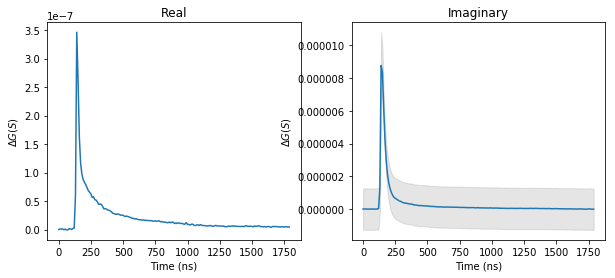

In [189]:
fig, axes = plt.subplots(1,2, figsize = (10,4), sharey = False)
fluencesel = -1
uc = True

for sample in sigi.indexes['sample']:
    s = sigi.sel(sample = sample).dropna('fluence','all').isel(fluence = fluencesel).sel(direction = 'U').dropna('time','all').to_series()
    axes[1].xaxis.set_major_formatter(FuncFormatter(plot.exp_formatter(-9).func))
    axes[1].set_xlabel('Time (ns)')
    axes[1].plot(s, label = sample)
    axes[1].set_title('Imaginary')
    axes[1].set_ylabel('$\Delta G (S)$')

    if uc:
        su = sigiu.sel(sample = sample).dropna('fluence','all').isel(fluence = fluencesel).sel(direction = 'U').dropna('time','all').to_series()
        axes[1].fill_between(s.index, (s-su).values, (s+su).values, alpha = 0.1, color = 'black')
    
    s = sigr.sel(sample = sample).dropna('fluence','all').isel(fluence = fluencesel).sel(direction = 'U').dropna('time','all').to_series()
    axes[0].xaxis.set_major_formatter(FuncFormatter(plot.exp_formatter(-9).func))
    axes[0].set_xlabel('Time (ns)')
    axes[0].plot(s, label = sample)
    axes[0].set_title('Real')
    axes[0].set_ylabel('$\Delta G (S)$')
    if uc:
        su = sigru.sel(sample = sample).dropna('fluence','all').isel(fluence = fluencesel).sel(direction = 'U').dropna('time','all').to_series()
        axes[0].fill_between(s.index, (s-su).values, (s+su).values, alpha = 0.1, color = 'black')

plt.legend()
# plt.yscale('log')
fig.suptitle('Fitted $\Delta$G', y = 1.08)
fig.tight_layout()